# App Rating Predicter 

The objective of this project is to predict the rating of apps in the google play store based on the information provided on the apps.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
%matplotlib inline

In [2]:
apps = pd.read_csv("googleplaystore.csv")

I imported all the necessary packages for my analysis and imported the dataset into the 'apps' variable.

## Cleaning Data

In [3]:
apps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          9367 non-null   float64
 3   Reviews         10841 non-null  object 
 4   Size            10841 non-null  object 
 5   Installs        10841 non-null  object 
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10841 non-null  object 
 11  Current Ver     10833 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


In [4]:
apps.head(5)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


### Dropping Missing and Unneeded Values

There are a lot of missing values in Rating. Since I will be using this column to train my model later, I need to remove these rows.

In [5]:
apps_no_nulls = apps[apps.Rating.isnull()==False]

In [6]:
apps_no_nulls.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9367 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             9367 non-null   object 
 1   Category        9367 non-null   object 
 2   Rating          9367 non-null   float64
 3   Reviews         9367 non-null   object 
 4   Size            9367 non-null   object 
 5   Installs        9367 non-null   object 
 6   Type            9367 non-null   object 
 7   Price           9367 non-null   object 
 8   Content Rating  9366 non-null   object 
 9   Genres          9367 non-null   object 
 10  Last Updated    9367 non-null   object 
 11  Current Ver     9363 non-null   object 
 12  Android Ver     9364 non-null   object 
dtypes: float64(1), object(12)
memory usage: 1.0+ MB


There are still a few missing values in Content Rating, Current Ver and Android Ver.  I  don't need the Current Ver or Android Ver columns for my analysis, so I will be dropping these columns. I also don't need the Last Updated column and will be dropping it. The Genres column is very similar to Category and has high cardinality. I will be reomving this column. That only leaves 1 missing value in Content Rating. I will be removing this row.

<u>Work</u>

In [7]:
apps_no_nulls = apps_no_nulls[apps_no_nulls['Content Rating'].isnull()==False]

In [8]:
apps_no_nulls.drop(['Current Ver','Android Ver','Last Updated','Genres'],axis=1,inplace = True)

In [9]:
apps_no_nulls.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9366 entries, 0 to 10840
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             9366 non-null   object 
 1   Category        9366 non-null   object 
 2   Rating          9366 non-null   float64
 3   Reviews         9366 non-null   object 
 4   Size            9366 non-null   object 
 5   Installs        9366 non-null   object 
 6   Type            9366 non-null   object 
 7   Price           9366 non-null   object 
 8   Content Rating  9366 non-null   object 
dtypes: float64(1), object(8)
memory usage: 731.7+ KB


## Type Conversion and Formatting Corrections

I would also like to look at the types of each column and see if they are appropriate.
<p><b>a.</b> The first column that looks off is the Size column. This column has MB and KB units in each cell and is therefore a string type. I would like to use KB as the consistent unit of measure and I would like to convert this column into an float data type. It also has a value of 'Varies with device'. I will need to drop these values.

In [10]:
apps_no_nulls['Size'].value_counts()

Varies with device    1637
14M                    166
12M                    161
11M                    160
15M                    159
                      ... 
190k                     1
636k                     1
691k                     1
478k                     1
371k                     1
Name: Size, Length: 414, dtype: int64

In [11]:
apps_no_nulls[apps_no_nulls['Size']=='Varies with device'].head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating
37,Floor Plan Creator,ART_AND_DESIGN,4.1,36639,Varies with device,"5,000,000+",Free,0,Everyone
42,Textgram - write on photos,ART_AND_DESIGN,4.4,295221,Varies with device,"10,000,000+",Free,0,Everyone
52,Used Cars and Trucks for Sale,AUTO_AND_VEHICLES,4.6,17057,Varies with device,"1,000,000+",Free,0,Everyone
67,Ulysse Speedometer,AUTO_AND_VEHICLES,4.3,40211,Varies with device,"5,000,000+",Free,0,Everyone
68,REPUVE,AUTO_AND_VEHICLES,3.9,356,Varies with device,"100,000+",Free,0,Everyone


<u>Work</u>

In [12]:
apps_no_nulls.drop(apps_no_nulls[apps_no_nulls['Size']=='Varies with device'].index,axis=0,inplace = True)

In [13]:
def no_k_or_m(row):
    if 'M' in row:
        row_copy = row.replace('M','')
        return float(row_copy)*1000
    if 'k' in row:
        row = row.replace('k','')
        return float(row)

In [14]:
apps_no_nulls['Size'] = apps_no_nulls['Size'].apply(no_k_or_m)

In [15]:
apps_no_nulls.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7729 entries, 0 to 10840
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             7729 non-null   object 
 1   Category        7729 non-null   object 
 2   Rating          7729 non-null   float64
 3   Reviews         7729 non-null   object 
 4   Size            7729 non-null   float64
 5   Installs        7729 non-null   object 
 6   Type            7729 non-null   object 
 7   Price           7729 non-null   object 
 8   Content Rating  7729 non-null   object 
dtypes: float64(2), object(7)
memory usage: 603.8+ KB


<b>b.</b> I also want to change the type of reviews to int.

In [16]:
apps_no_nulls['Reviews'].value_counts().head()

2    82
3    77
5    74
4    72
1    66
Name: Reviews, dtype: int64

<u>Work

In [17]:
apps_no_nulls['Reviews'] = apps_no_nulls['Reviews'].astype('int64')

In [18]:
apps_no_nulls['Reviews'].value_counts().head()

2    82
3    77
5    74
4    72
1    66
Name: Reviews, dtype: int64

<b>c.</b> The Installs column has '+' and ',' in the values so it is a string data type. I will be removing these characters and converting it to an integer.

In [19]:
apps_no_nulls['Installs'].value_counts().head()

1,000,000+     1302
100,000+       1037
10,000+         969
10,000,000+     825
1,000+          690
Name: Installs, dtype: int64

<u>Work

In [20]:
apps_no_nulls['Installs'] = apps_no_nulls['Installs'].str.replace(r'[\+,]','',regex=True)

In [21]:
apps_no_nulls['Installs'] = apps_no_nulls['Installs'].astype('int64')

In [22]:
apps_no_nulls['Installs'].value_counts().head()

1000000     1302
100000      1037
10000        969
10000000     825
1000         690
Name: Installs, dtype: int64

<b>d.</b> Now I want to remeove the $ from the Price column and convert it to a float data type.

In [23]:
apps_no_nulls['Price'].value_counts().head()

0        7150
$0.99     106
$2.99     101
$4.99      63
$1.99      53
Name: Price, dtype: int64

<u>Work

In [24]:
apps_no_nulls['Price'] = apps_no_nulls['Price'].str.replace('$','',regex=True)

In [25]:
apps_no_nulls['Price'] = apps_no_nulls['Price'].astype('float')

In [26]:
apps_no_nulls['Price'].value_counts().head()

0.00    7150
0.99     106
2.99     101
4.99      63
1.99      53
Name: Price, dtype: int64

## Check Data for Inconsistencies

In [27]:
apps_no_nulls_tc_and_formatted = apps_no_nulls.copy()

<b>a.</b> The average rating of an app should fall between 1 and 5 as this is the acceptable range of values for a rating on the Play Store.

In [28]:
apps_no_nulls_tc_and_formatted.describe()

,Rating,Reviews,Size,Installs,Price
count,7729.000000,7.729000e+03,7729.000000,7.729000e+03,7729.000000
mean,4.173852,2.946726e+05,22957.606870,8.417734e+06,1.127614
std,0.544563,1.863227e+06,23445.491095,5.013846e+07,17.401297
min,1.000000,1.000000e+00,8.500000,1.000000e+00,0.000000
25%,4.000000,1.080000e+02,5300.000000,1.000000e+04,0.000000
50%,4.300000,2.328000e+03,14000.000000,1.000000e+05,0.000000
75%,4.500000,3.896100e+04,33000.000000,1.000000e+06,0.000000
max,5.000000,4.489389e+07,100000.000000,1.000000e+09,400.000000


The min for the Rating column is 1 and the max is 5. This is correct.

<b>b.</b> There are apps that are of type='Free'. I want to make sure that all of these apps are marked with a price of 0.

In [29]:
apps_no_nulls_tc_and_formatted['Price'].value_counts().head()

0.00    7150
0.99     106
2.99     101
4.99      63
1.99      53
Name: Price, dtype: int64

In [30]:
apps_no_nulls_tc_and_formatted.loc[apps_no_nulls_tc_and_formatted['Type']=='Free',['Price']].value_counts()

Price
0.0      7150
dtype: int64

The number of \\$0 apps is 7150 and the apps of Type='Free', of which there are 7150, only have a price of $0. This means there is no inconsistency bewteen these two columns. I will now drop the Type column because I won't need it anymore. This data can be retrieved from the Price column if needed.

In [31]:
apps_no_nulls_tc_and_formatted = apps_no_nulls_tc_and_formatted.drop('Type',axis='columns')

<b>c.</b> I want to check if there are apps with more reviews than they should. I will be using the Installs column for this. 

In [32]:
apps_no_nulls_tc_and_formatted[apps_no_nulls_tc_and_formatted.Reviews>apps_no_nulls_tc_and_formatted.Installs]

,App,Category,Rating,Reviews,Size,Installs,Price,Content Rating
2454,KBA-EZ Health Guide,MEDICAL,5.0,4,25000.0,1,0.00,Everyone
5917,Ra Ga Ba,GAME,5.0,2,20000.0,1,1.49,Everyone
6700,Brick Breaker BR,GAME,5.0,7,19000.0,5,0.00,Everyone
7402,Trovami se ci riesci,GAME,5.0,11,6100.0,10,0.00,Everyone
8591,DN Blog,SOCIAL,5.0,20,4200.0,10,0.00,Teen
10697,Mu.F.O.,GAME,5.0,2,16000.0,1,0.99,Everyone


There are several apps with more ratings than installs however, this is because I took out the '+' at the end of Installs which means Installs used to be a range of values. All the values of Reviews are less than the floor of the next bin of Installs (1->5->10->100), so I will be keeping all these rows since they make sense with how the data was first structured.

## Outlier analysis

Next I want to see if there are any outliers found in some of the columns.
<p><b>a.</b> I will look at the Price column first.

Text(0.5, 1.0, 'Price($) Boxplot')

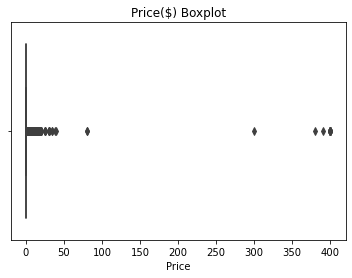

In [33]:
sns.boxplot(x=apps_no_nulls_tc_and_formatted.Price)
plt.title('Price($) Boxplot')

Text(0.5, 1.0, 'Price($) Boxplot')

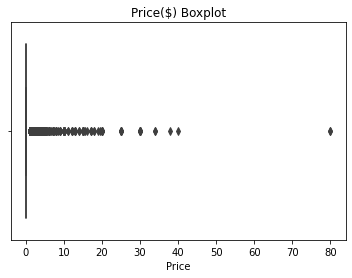

In [34]:
sns.boxplot(x=apps_no_nulls_tc_and_formatted.loc[apps_no_nulls_tc_and_formatted.Price<200,'Price'])
plt.title('Price($) Boxplot')

Most of the apps are free so everything above that is being listed as an outlier. However, within these outliers I can see some cutoffs, one at \\$20 and another at $300. I want to see what these apps are.

In [35]:
apps_no_nulls_tc_and_formatted.loc[apps_no_nulls_tc_and_formatted.Price>20].sort_values('Price')

,App,Category,Rating,Reviews,Size,Installs,Price,Content Rating
2251,Human Anatomy Atlas 2018: Complete 3D Human Body,MEDICAL,4.5,2921,25000.0,100000,24.99,Everyone
2407,"Muscle Premium - Human Anatomy, Kinesiology, B...",MEDICAL,4.2,168,25000.0,10000,24.99,Everyone
2372,Human Anatomy Atlas 2018: Complete 3D Human Body,MEDICAL,4.5,2921,25000.0,100000,24.99,Everyone
9574,Human Anatomy Atlas 2018: Complete 3D Human Body,MEDICAL,4.5,2923,25000.0,100000,24.99,Everyone
2277,"Muscle Premium - Human Anatomy, Kinesiology, B...",MEDICAL,4.2,168,25000.0,10000,24.99,Everyone
2298,PTA Content Master,MEDICAL,4.2,64,41000.0,1000,29.99,Everyone
5489,AP Art History Flashcards,FAMILY,5.0,1,96000.0,10,29.99,Mature 17+
2406,PTA Content Master,MEDICAL,4.2,64,41000.0,1000,29.99,Everyone
3039,Golfshot Plus: Golf GPS,SPORTS,4.1,3387,25000.0,50000,29.99,Everyone
2266,EMT PASS,MEDICAL,3.4,51,2400.0,1000,29.99,Everyone


It looks like the apps that cost \\$300 or more are outliers. They are apps people buy to brag about their wealth and seem to serve on other purpose. I will be dropping these apps as they will skew my analysis. The other apps are learning apps, mostly medical, so I'll leave them in.

In [36]:
apps_no_nulls_tc_and_formatted.shape

(7729, 8)

In [37]:
apps_no_nulls_tc_and_formatted = apps_no_nulls_tc_and_formatted.loc[apps_no_nulls_tc_and_formatted.Price<200]

In [38]:
apps_no_nulls_tc_and_formatted.shape

(7714, 8)

<b>b.</b> Next I will look at the Reviews column.

Text(0.5, 1.0, 'Reviews Boxplot')

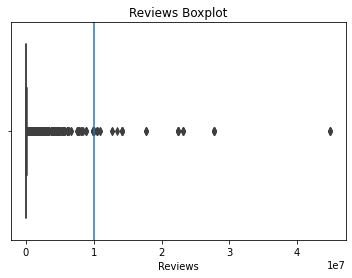

In [39]:
ax = sns.boxplot(x=apps_no_nulls_tc_and_formatted.Reviews)
plt.axvline(1e7)
plt.title('Reviews Boxplot')

Text(0.5, 1.0, 'Reviews<1e7 Boxplot')

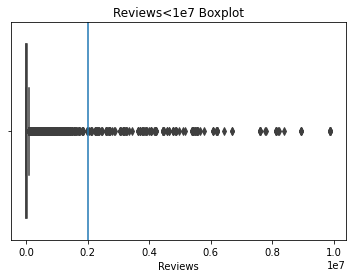

In [40]:
ax =sns.boxplot(x=apps_no_nulls_tc_and_formatted.loc[apps_no_nulls_tc_and_formatted.Reviews<1e7,'Reviews'])
plt.axvline(2e6)
plt.title('Reviews<1e7 Boxplot')

Text(0.5, 1.0, 'Reviews<1e7 Boxplot')

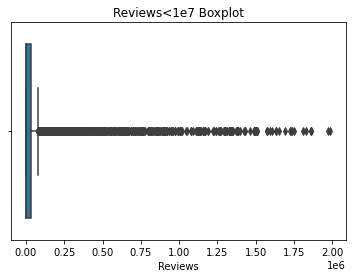

In [41]:
ax =sns.boxplot(x=apps_no_nulls_tc_and_formatted.loc[apps_no_nulls_tc_and_formatted.Reviews<2e6,'Reviews'])
plt.title('Reviews<1e7 Boxplot')

I will be looking at the rows with Reviews greater than or equal to 2e6 because there looks to be a sectioning off there.

In [42]:
apps_no_nulls_tc_and_formatted.loc[apps_no_nulls_tc_and_formatted.Reviews>2e6]

,App,Category,Rating,Reviews,Size,Installs,Price,Content Rating
345,Yahoo Mail – Stay Organized,COMMUNICATION,4.3,4187998,16000.0,100000000,0.0,Everyone
347,imo free video calls and chat,COMMUNICATION,4.3,4785892,11000.0,500000000,0.0,Everyone
366,UC Browser Mini -Tiny Fast Private & Secure,COMMUNICATION,4.4,3648120,3300.0,100000000,0.0,Teen
378,UC Browser - Fast Download Private & Secure,COMMUNICATION,4.5,17712922,40000.0,500000000,0.0,Teen
383,imo free video calls and chat,COMMUNICATION,4.3,4785988,11000.0,500000000,0.0,Everyone
...,...,...,...,...,...,...,...,...
9142,Need for Speed™ No Limits,GAME,4.4,3344300,22000.0,50000000,0.0,Everyone 10+
9166,Modern Combat 5: eSports FPS,GAME,4.3,2903386,58000.0,100000000,0.0,Mature 17+
10186,Farm Heroes Saga,FAMILY,4.4,7615646,71000.0,100000000,0.0,Everyone
10190,Fallout Shelter,FAMILY,4.6,2721923,25000.0,10000000,0.0,Teen


In [43]:
apps_no_nulls_tc_and_formatted.App.value_counts()

ROBLOX                              9
8 Ball Pool                         7
Candy Crush Saga                    7
Subway Surfers                      6
Helix Jump                          6
                                   ..
CA Auth ID                          1
Tsuro - The Game of the Path        1
Zombie Defense                      1
Teen Titans GO Figure!              1
Sworkit Kids - Fitness Meets Fun    1
Name: App, Length: 7014, dtype: int64

As I've gone thru the apps with very large numbers of reviews, I have discovered there are duplicates for some apps. From my inspection, the duplicates are very similar. Therefore I will be dropping the duplicates and keeping the first instance. 

In [44]:
apps_no_nulls_tc_and_formatted = apps_no_nulls_tc_and_formatted.drop_duplicates(subset='App', keep='last')

Text(0.5, 1.0, 'Reviews Boxplot')

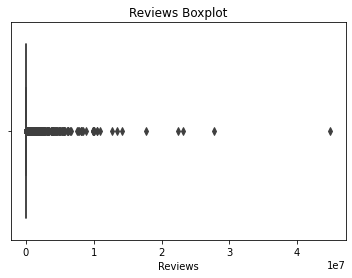

In [45]:
sns.boxplot(x=apps_no_nulls_tc_and_formatted.Reviews)
plt.title('Reviews Boxplot')

In [46]:
apps_no_nulls_tc_and_formatted.loc[apps_no_nulls_tc_and_formatted.Reviews>2e6]

,App,Category,Rating,Reviews,Size,Installs,Price,Content Rating
395,"GO SMS Pro - Messenger, Free Themes, Emoji",COMMUNICATION,4.4,2876500,24000.0,100000000,0.0,Everyone
1773,Extreme Car Driving Simulator,GAME,4.3,2251012,52000.0,100000000,0.0,Everyone
1781,Trivia Crack,GAME,4.5,6427773,95000.0,100000000,0.0,Everyone
1861,Summoners War,GAME,4.3,2045554,28000.0,50000000,0.0,Teen
1866,Lords Mobile: Battle of the Empires - Strategy...,GAME,4.4,3057481,14000.0,50000000,0.0,Teen
...,...,...,...,...,...,...,...,...
9142,Need for Speed™ No Limits,GAME,4.4,3344300,22000.0,50000000,0.0,Everyone 10+
9166,Modern Combat 5: eSports FPS,GAME,4.3,2903386,58000.0,100000000,0.0,Mature 17+
10186,Farm Heroes Saga,FAMILY,4.4,7615646,71000.0,100000000,0.0,Everyone
10190,Fallout Shelter,FAMILY,4.6,2721923,25000.0,10000000,0.0,Teen


With the duplicates dropped, there are fewer apps with reviews numbering greater than 2e6. I would call these apps abnormally popular, and with there very large number of reviews, they will skew my analysis. I will drop these rows.

In [47]:
apps_no_nulls_tc_and_formatted = apps_no_nulls_tc_and_formatted.loc[apps_no_nulls_tc_and_formatted.Reviews<=2e6]

<b>c.</b> Next up I want to check if the install amounts have outliers. Getting rid of the Reviews outliers may have done this already, but I would like to double check.

In [48]:
apps_no_nulls_tc_and_formatted.Installs.value_counts().sort_index()

1                3
5                9
10              67
50              56
100            295
500            195
1000           670
5000           410
10000          943
50000          426
100000         990
500000         460
1000000       1177
5000000        450
10000000       640
50000000        88
100000000       33
500000000        2
1000000000       1
Name: Installs, dtype: int64

In [49]:
apps_no_nulls_tc_and_formatted.Installs.describe()

count    6.915000e+03
mean     2.876295e+06
std      1.730022e+07
min      1.000000e+00
25%      1.000000e+04
50%      1.000000e+05
75%      1.000000e+06
max      1.000000e+09
Name: Installs, dtype: float64

Text(0.5, 1.0, 'Installs Logscale Histogram')

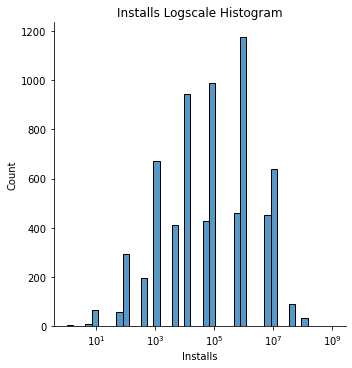

In [50]:
sns.displot(apps_no_nulls_tc_and_formatted.Installs,log_scale=True)
plt.title('Installs Logscale Histogram')

<AxesSubplot:title={'center':'Installs Logscale Boxplot'}, xlabel='Installs'>

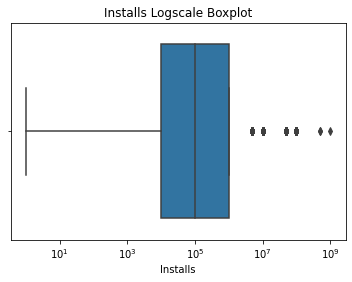

In [51]:
fig,ax = plt.subplots()
ax.set_xscale('log')
plt.title('Installs Logscale Boxplot')
sns.boxplot(x = apps_no_nulls_tc_and_formatted.Installs)

I want to get rid of some of the outliers so that my analysis isn't skewed by them. The possible outliers start from 5e6 and go up. Getting rid of all values above this would remove ~18% of the data that is left. Therefore I will make the cutoff at 1e7 which will only drop ~2% of the data.

In [52]:
apps_no_nulls_tc_and_formatted = apps_no_nulls_tc_and_formatted[apps_no_nulls_tc_and_formatted.Installs<=1e7]

In [53]:
apps_no_nulls_tc_and_formatted.Installs.value_counts().sort_index()

1              3
5              9
10            67
50            56
100          295
500          195
1000         670
5000         410
10000        943
50000        426
100000       990
500000       460
1000000     1177
5000000      450
10000000     640
Name: Installs, dtype: int64

<b>d.</b> Next I want to look at the distribution of Rating to see if there are any outliers.

Text(0.5, 1.0, 'Rating Histogram')

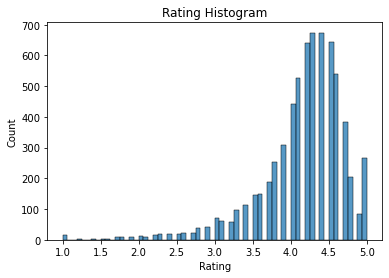

In [54]:
sns.histplot(apps_no_nulls_tc_and_formatted.Rating)
plt.title('Rating Histogram')

In [55]:
apps_no_nulls_tc_and_formatted.Rating.value_counts().sort_index()

1.0     16
1.2      1
1.4      3
1.5      3
1.6      4
1.7      8
1.8      8
1.9     10
2.0     11
2.1      8
2.2     14
2.3     20
2.4     19
2.5     18
2.6     23
2.7     21
2.8     40
2.9     42
3.0     72
3.1     61
3.2     59
3.3     96
3.4    113
3.5    146
3.6    150
3.7    187
3.8    252
3.9    310
4.0    441
4.1    528
4.2    639
4.3    672
4.4    674
4.5    645
4.6    539
4.7    384
4.8    203
4.9     85
5.0    266
Name: Rating, dtype: int64

In [56]:
apps_no_nulls_tc_and_formatted[apps_no_nulls_tc_and_formatted.Rating<2].sort_values('Rating')

,App,Category,Rating,Reviews,Size,Installs,Price,Content Rating
625,House party - live chat,DATING,1.0,1,9200.0,10,0.00,Mature 17+
10400,Familial Hypercholesterolaemia Handbook,MEDICAL,1.0,2,33000.0,100,0.00,Everyone
10324,FE Mechanical Engineering Prep,FAMILY,1.0,2,21000.0,1000,0.00,Everyone
8875,DT future1 cam,TOOLS,1.0,1,24000.0,50,0.00,Everyone
8820,DS Creator 2.0,TOOLS,1.0,2,4400.0,500,0.00,Everyone
7926,Tech CU Card Manager,FINANCE,1.0,2,7200.0,1000,0.00,Everyone
7806,CR Magazine,BUSINESS,1.0,1,7800.0,100,0.00,Everyone
7427,CJ DVD Rentals,COMMUNICATION,1.0,5,13000.0,100,0.00,Everyone
7383,Thistletown CI,PRODUCTIVITY,1.0,1,6600.0,100,0.00,Everyone
7144,CB Mobile Biz,FINANCE,1.0,3,8400.0,500,0.00,Everyone


The Ratings are skewed to the left however, the range is only from 1 to 5 which is small. I also want data for these lower ratings to be able to train our model for that range.

<b>e.</b> Lastly I want to look at the Size column.

Text(0.5, 1.0, 'Size(kb) Histogram')

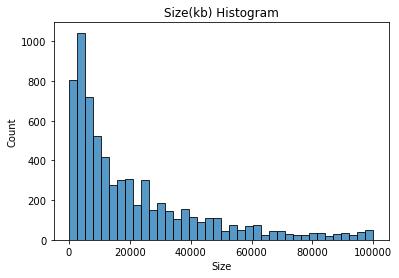

In [57]:
sns.histplot(apps_no_nulls_tc_and_formatted.Size)
plt.title('Size(kb) Histogram')

Text(0.5, 1.0, 'Size(kb) Boxplot')

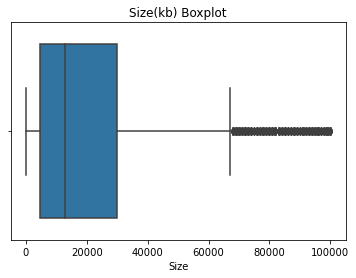

In [58]:
sns.boxplot(x=apps_no_nulls_tc_and_formatted.Size)
plt.title('Size(kb) Boxplot')

The Size distribution is skewed to the right. In the boxplot, the possible outliers are all within 3IQR. Because of this, I will not be dropping any rows.

## Bivariate Analysis

I want to see the relationship between Rating and my other columns. I will be using scatterplots for numerical columns and boxplots for categorical data.

In [59]:
apps_cleaned = apps_no_nulls_tc_and_formatted.copy().reset_index(drop = True)

Dropping rows that are unrated or adults only. They only make up 3 of the apps which is too low to do analysis on.

In [60]:
apps_cleaned = apps_cleaned.loc[apps_cleaned['Content Rating'].isin(['Adults only 18+','Unrated'])==False].reset_index(drop = True)

<b>a.</b> First, I'll be taking a look at the scatter plot of Rating vs. Price.

Text(0.5, 1.0, 'Rating vs. Price')

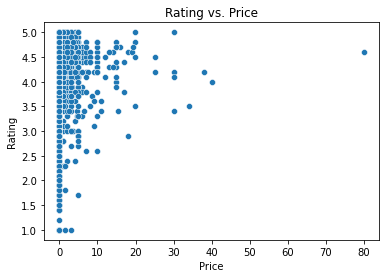

In [61]:
ax = sns.scatterplot(x=apps_cleaned.Price,y=apps_cleaned.Rating)
plt.title('Rating vs. Price')

Text(0.5, 1.0, 'Rating vs. Price, No Free Apps')

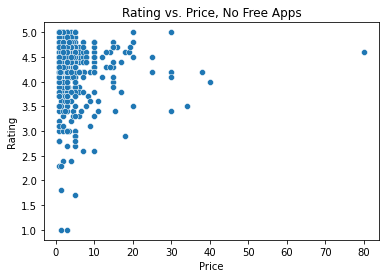

In [62]:
ax = sns.scatterplot(x=apps_cleaned.loc[apps_cleaned.Price>0,'Price'],y=apps_cleaned.Rating)
plt.title('Rating vs. Price, No Free Apps')

<p>Most Apps are free and they have Ratings that span the entire range. When looking at apps that cost money, as the price goes up, the ratings become better. This isn't exact, There are many free and low cost apps with ratings close to 5, but the low ratings disappear as the price goes up.</p>
<p> This follows the logic that people tend to think better of things the more they spend on it.

<b>b.</b> Next, I will be looking at Rating vs. Size

Text(0.5, 1.0, 'Rating vs. Size(kb)')

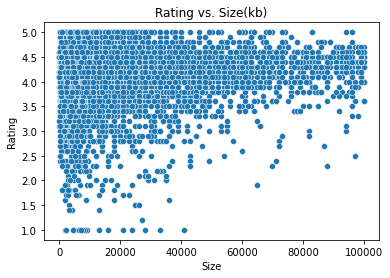

In [63]:
ax = sns.scatterplot(x=apps_cleaned.Size,y=apps_cleaned.Rating)
plt.title('Rating vs. Size(kb)')

Text(0.5, 1.0, 'Rating vs. Size(kb) Logscale')

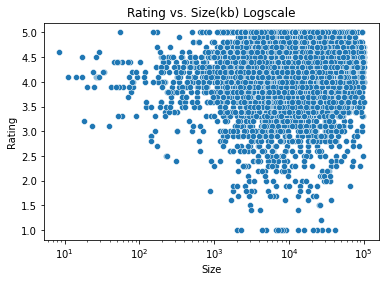

In [64]:
ax = sns.scatterplot(x=apps_cleaned.Size,y=apps_cleaned.Rating)
ax.set_xscale('log')
plt.title('Rating vs. Size(kb) Logscale')

<p>When looking at the graph in a linear scale, the apps that are larger than 45000kb tend to stop having ratings below 2. There also seems to be a trend towards higher ratings as the size of the app goes up.</p>
<p>When looking at the graph in logscale, it also seems simpler apps, apps smaller than 1000kb, tend to have better ratings.</p>
<p> I can see this as people liking apps that have a specific use, and more complex apps that are fleshed out and work well. I would also like to see if these large size apps fall into a certain category such as gameing.</p>
<p><b>c.</b> Now I will be looking at Rating vs. Reviews

Text(0.5, 1.0, 'Rating vs. Reviews')

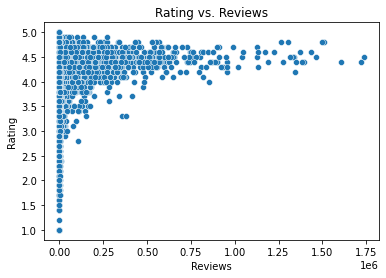

In [65]:
ax =sns.scatterplot(x=apps_cleaned.Reviews,y=apps_cleaned.Rating)
plt.title('Rating vs. Reviews')

Text(0.5, 1.0, 'Rating vs. Reviews Logscale')

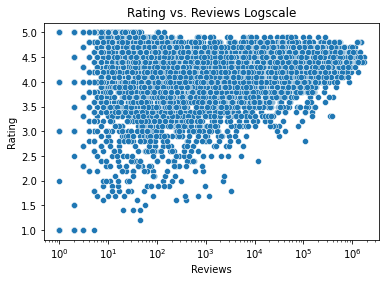

In [66]:
ax =sns.scatterplot(x=apps_cleaned.Reviews,y=apps_cleaned.Rating)
ax.set_xscale('log')
plt.title('Rating vs. Reviews Logscale')

<p>The larger the number of reviews, the better the Rating. This can be seen in the logscale graph, where after about 200 reviews, the ratings start to increase and the low ratings begin to disappear. In the linear scale  it can be seen that apps with many, many reviews have high ratings and no low ratings.</p>
<p> This makes sense, as only "good" apps would be installeded and reviewed so much.</p>
<p><b>d.</b> I will now be looking at categorical variables and box plots. The first is Rating vs. Category.

In [67]:
#filling a dataframe with the decribe() data for each category
categories = pd.DataFrame()
for i in apps_cleaned.Category.value_counts().sort_index().index:
    categories[i] = apps_cleaned.loc[apps_cleaned.Category==i,'Rating'].describe()

In [68]:
#adding IQR to the describe() data
IQR = pd.Series(categories.loc['75%']-categories.loc['25%'], name='IQR')
categories = categories.append(IQR)

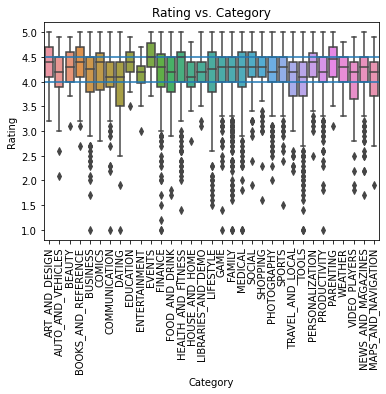

,ART_AND_DESIGN,AUTO_AND_VEHICLES,BEAUTY,BOOKS_AND_REFERENCE,BUSINESS,COMICS,COMMUNICATION,DATING,EDUCATION,ENTERTAINMENT,EVENTS,FAMILY,FINANCE,FOOD_AND_DRINK,GAME,HEALTH_AND_FITNESS,HOUSE_AND_HOME,LIBRARIES_AND_DEMO,LIFESTYLE,MAPS_AND_NAVIGATION,MEDICAL,NEWS_AND_MAGAZINES,PARENTING,PERSONALIZATION,PHOTOGRAPHY,PRODUCTIVITY,SHOPPING,SOCIAL,SPORTS,TOOLS,TRAVEL_AND_LOCAL,VIDEO_PLAYERS,WEATHER
count,56.000000,63.000000,37.000000,141.000000,218.000000,46.000000,182.000000,122.000000,75.000000,48.000000,38.000000,1514.000000,251.000000,72.000000,726.000000,190.000000,49.000000,61.000000,262.000000,93.000000,267.000000,153.000000,44.000000,270.000000,191.000000,215.000000,142.000000,152.000000,214.000000,603.000000,141.000000,103.000000,49.000000
mean,4.360714,4.147619,4.291892,4.322695,4.093578,4.158696,4.064286,3.963934,4.357333,4.147917,4.478947,4.182629,4.107171,4.108333,4.212534,4.190526,4.116327,4.203279,4.098473,4.004301,4.165543,4.145098,4.347727,4.321111,4.092147,4.122326,4.209155,4.255921,4.197196,3.993367,4.011348,3.991262,4.238776
std,0.367141,0.565359,0.370719,0.461886,0.693522,0.558401,0.527675,0.665820,0.287192,0.328756,0.351182,0.526981,0.702815,0.608103,0.412254,0.740595,0.384787,0.370120,0.730400,0.563551,0.705625,0.615367,0.415115,0.371222,0.547810,0.597553,0.477568,0.507132,0.491230,0.646012,0.571351,0.611669,0.348698
min,3.200000,2.100000,3.100000,2.700000,1.000000,2.800000,1.000000,1.000000,3.500000,3.000000,3.700000,1.000000,1.000000,1.700000,1.000000,1.400000,2.800000,3.100000,1.500000,1.900000,1.000000,1.700000,3.100000,2.500000,2.000000,1.000000,1.600000,1.900000,1.500000,1.000000,2.200000,1.800000,3.300000
25%,4.100000,3.900000,4.000000,4.100000,3.800000,3.825000,3.900000,3.500000,4.200000,3.975000,4.300000,4.000000,3.900000,3.800000,4.000000,4.000000,3.900000,4.000000,3.800000,3.700000,3.900000,4.000000,4.100000,4.100000,4.000000,4.000000,4.100000,4.100000,4.000000,3.700000,3.700000,3.650000,4.000000
50%,4.400000,4.200000,4.300000,4.400000,4.250000,4.400000,4.100000,4.100000,4.400000,4.200000,4.500000,4.300000,4.300000,4.200000,4.300000,4.500000,4.100000,4.200000,4.250000,4.200000,4.300000,4.300000,4.450000,4.400000,4.200000,4.200000,4.300000,4.300000,4.300000,4.100000,4.200000,4.200000,4.300000
75%,4.700000,4.500000,4.600000,4.700000,4.500000,4.575000,4.400000,4.400000,4.600000,4.325000,4.775000,4.500000,4.550000,4.500000,4.500000,4.600000,4.400000,4.400000,4.600000,4.400000,4.600000,4.500000,4.700000,4.575000,4.500000,4.500000,4.500000,4.600000,4.500000,4.400000,4.400000,4.400000,4.500000
max,5.000000,4.900000,4.900000,5.000000,5.000000,5.000000,5.000000,5.000000,4.900000,4.700000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,4.800000,5.000000,5.000000,4.900000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,4.900000,4.800000
IQR,0.600000,0.600000,0.600000,0.600000,0.700000,0.750000,0.500000,0.900000,0.400000,0.350000,0.475000,0.500000,0.650000,0.700000,0.500000,0.600000,0.500000,0.400000,0.800000,0.700000,0.700000,0.500000,0.600000,0.475000,0.500000,0.500000,0.400000,0.500000,0.500000,0.700000,0.700000,0.750000,0.500000


In [69]:
ax = sns.boxplot(x=apps_cleaned.Category,y=apps_cleaned.Rating)
plt.xticks(rotation=90)
plt.axhline(4.5)
plt.axhline(4)
plt.title('Rating vs. Category')
plt.show()
#showing all columns in categories
pd.set_option('display.max_columns', None)
display(categories)
#resetting max columns displayed to 20
pd.set_option('display.max_columns', 20)

All categories have their medians between 4 and 4.5. However, there are some app categories that do better. For instance, there are three apps with more than 50% of their ratings above 4.5. They are Events, Health and Fitness, and Parenting. Events also has the highest minimum rating at 3.7. Whereas entertainment apps have the smallest variance in rating with an IQR of 0.35.
<p><b>e.</b> Lastly, I will be looking at the box plots of Rating vs Category.

In [70]:
#filling a dataframe with the decribe() data for each category
content_rating = pd.DataFrame()
for i in apps_cleaned['Content Rating'].value_counts().index:
    content_rating[i] = apps_cleaned.loc[apps_cleaned['Content Rating']==i,'Rating'].describe()

In [71]:
#adding IQR to the describe() data
IQR = pd.Series(content_rating.loc['75%']-content_rating.loc['25%'], name='IQR')
content_rating = content_rating.append(IQR)

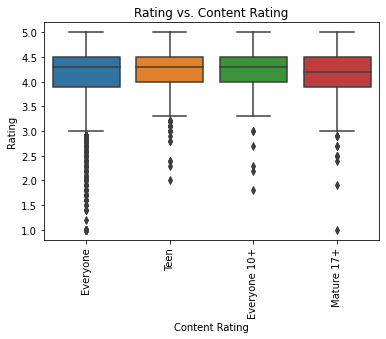

,Everyone,Teen,Mature 17+,Everyone 10+
count,5520.000000,729.000000,298.000000,241.000000
mean,4.146775,4.216049,4.104027,4.214523
std,0.587556,0.427750,0.543945,0.427001
min,1.000000,2.000000,1.000000,1.800000
25%,3.900000,4.000000,3.900000,4.000000
50%,4.300000,4.300000,4.200000,4.300000
75%,4.500000,4.500000,4.500000,4.500000
max,5.000000,5.000000,5.000000,5.000000
IQR,0.600000,0.500000,0.600000,0.500000


In [72]:
ax = sns.boxplot(x=apps_cleaned['Content Rating'],y=apps_cleaned.Rating)
plt.xticks(rotation=90)
plt.title('Rating vs. Content Rating')
plt.show()
#showing all columns in categories
pd.set_option('display.max_columns', None)
display(content_rating)
#resetting max columns displayed to 20
pd.set_option('display.max_columns', 20)

The Content Ratings have similar boxplots. The Teen and Everyone 10+ content ratings do slightly better than the other two in terms of median and IQR.

## Preprocessing for linear regression

I need to drop the App column, log transform the Installs and Reviews columns, and make dummy variables for Category, Genres, and Content Rating.
<p><b>a.</b> I will be dropping the App Column first.

In [73]:
inp2 = apps_cleaned.copy()

In [74]:
inp2 = inp2.drop('App',axis=1)

<p><b>b.</b> I will be log transforming the Installs and Reviews columns and dropping the old columns next.

In [75]:
inp2['Installs_log']=np.log1p(inp2.Installs)
inp2['Reviews_log']=np.log1p(inp2.Reviews)
inp2 = inp2.drop(['Reviews','Installs'],axis=1)

In [76]:
inp2

,Category,Rating,Size,Price,Content Rating,Installs_log,Reviews_log
0,ART_AND_DESIGN,4.1,19000.0,0.0,Everyone,9.210440,5.075174
1,ART_AND_DESIGN,4.7,8700.0,0.0,Everyone,15.424949,11.379520
2,ART_AND_DESIGN,4.3,2800.0,0.0,Everyone,11.512935,6.875232
3,ART_AND_DESIGN,4.4,5600.0,0.0,Everyone,10.819798,5.123964
4,ART_AND_DESIGN,3.8,19000.0,0.0,Everyone,10.819798,5.187386
...,...,...,...,...,...,...,...
6783,BOOKS_AND_REFERENCE,4.8,619.0,0.0,Everyone,6.908755,3.806662
6784,FAMILY,4.0,2600.0,0.0,Everyone,6.216606,2.079442
6785,FAMILY,4.5,53000.0,0.0,Everyone,8.517393,3.663562
6786,FAMILY,5.0,3600.0,0.0,Everyone,4.615121,1.609438


<p><b>c.</b> I will be making dummy variables for Category, Genres, and Content Rating and dropping the old columns last.

In [77]:
#getting dummy variables for each categorical column and concatenating it to the dataframe
inp2 = pd.concat([inp2,pd.get_dummies(inp2[['Category','Content Rating']],drop_first=True)],axis=1)
#dropping old columns
inp2 = inp2.drop(['Category','Content Rating'],axis=1)

## Building Linear Regression Model

To build the model, I need to seperate my data into a testing dataframe and a training dataframe. I will use 70% of my data for the training dataframe and 30% for the testing dataset.

In [78]:
inp2

,Rating,Size,Price,Installs_log,Reviews_log,Category_AUTO_AND_VEHICLES,Category_BEAUTY,Category_BOOKS_AND_REFERENCE,Category_BUSINESS,Category_COMICS,...,Category_SHOPPING,Category_SOCIAL,Category_SPORTS,Category_TOOLS,Category_TRAVEL_AND_LOCAL,Category_VIDEO_PLAYERS,Category_WEATHER,Content Rating_Everyone 10+,Content Rating_Mature 17+,Content Rating_Teen
0,4.1,19000.0,0.0,9.210440,5.075174,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4.7,8700.0,0.0,15.424949,11.379520,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4.3,2800.0,0.0,11.512935,6.875232,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4.4,5600.0,0.0,10.819798,5.123964,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3.8,19000.0,0.0,10.819798,5.187386,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6783,4.8,619.0,0.0,6.908755,3.806662,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
6784,4.0,2600.0,0.0,6.216606,2.079442,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6785,4.5,53000.0,0.0,8.517393,3.663562,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6786,5.0,3600.0,0.0,4.615121,1.609438,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [79]:
#randomly selecting the rows for the training dataframe and seperating it into
#X and y values. random_state is used to reproduce the results.
df_train = inp2.sample(frac = .70,random_state=1)
X_train = df_train.drop('Rating',axis=1)
y_train = df_train.Rating
#Using the unused rows from inp2 for the testing dataframe and seperating it
#into X and y values.
df_test = inp2[inp2.index.isin(df_train.index)==False]
X_test = df_test.drop('Rating',axis=1)
y_test = df_test.Rating

In [80]:
regression = LinearRegression()
regression.fit(X_train,y_train)
r2_train = regression.score(X_train,y_train)
r2_train

0.1353131265305313

The R_2 value is 0.135 for the training set. This shows the modeldoes not fit the data well.

In [81]:
y_pred = regression.predict(X_test)
r2_test = r2_score(y_test,y_pred)
r2_test

0.12098318443583067

The R_2 value is 0.121 for the testing set. This shows the model is poor at predicting actual values.